# cVAE

## Imports

In [56]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import random

In [57]:
IMG_SIZE = 28
batch_size = 128
hidden_dims = 30


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Helpers 

In [58]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), IMG_SIZE, IMG_SIZE)
    return x

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

## Model

In [59]:
class cVAE(nn.Module):
    def __init__(self, img_width, img_height, n_class, hidden_dims=30):
        super(cVAE, self).__init__()
        
        self.img_width = img_width
        self.img_height = img_height
        self.input_size = img_width*img_height+n_class
        total_hidden_size = hidden_dims + n_class

        self.fc1 = nn.Linear(self.input_size,512)
        self.fc2_mu = nn.Linear(512, total_hidden_size)
        self.fc2_logvar = nn.Linear(512, total_hidden_size)

        self.relu = nn.ReLU()

        self.fc3 = nn.Linear(total_hidden_size, 512)
        self.fc4 = nn.Linear(512, img_width*img_height)

    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc2_mu(x), self.fc2_logvar(x)

    def decode(self, z, labels):
        torch.cat((z, labels), 1)
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, labels)
        return x_hat, mu, logvar

cVAE(28, 28, 10)

cVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2_mu): Linear(in_features=512, out_features=40, bias=True)
  (fc2_logvar): Linear(in_features=512, out_features=40, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=40, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=784, bias=True)
)

## Training 

In [60]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
CLASSES = 10

model = cVAE(IMG_WIDTH,IMG_HEIGHT, CLASSES).to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [61]:
def loss_function(x_hat, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(x_hat, x.view(-1, IMG_WIDTH * IMG_HEIGHT), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL-Divergence loss
    return BCE + KLD



In [62]:
def plot_val(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = 'binary')
    plt.show()

In [63]:
def train(train_loader, test_loader, num_epochs = 20):
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, labels in train_loader:
            x = x.to(device).view(x.size(0), 28*28)
            labels = torch.eye(9 + 1)[labels].to(device)
            
            # ===================forward=====================
            x_hat, mu, logvar = model(x, labels)
            loss = loss_function(x_hat, x[:, :784], mu, logvar)
            train_loss += loss.item()

            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

        # Testing 
        with torch.no_grad():
            model.eval()
            loss_sum = []
            for x, labels in test_loader:
                x = x.to(device).view(x.size(0), 28*28)
                labels = torch.eye(9 + 1)[labels].to(device)

                # ===================forward=====================
                x_hat, mu, logvar = model(x, labels)
                loss = loss_function(x_hat, x[:, :784], mu, logvar)
                loss_sum.append(loss)
            validation_losses.append((sum(loss_sum)/len(loss_sum)).item())
            plot_val([x[0].detach().cpu(),x_hat[0].detach().cpu()],28,28,1,2)
        plt.show()
    return validation_losses


In [64]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('../data', transform=transform, download=True)
train_data, test_data = torch.utils.data.random_split(dataset, (50000,10000))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

====> Epoch: 0 Average loss: -24391.5291


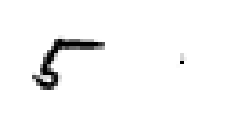

====> Epoch: 1 Average loss: -37374.8604


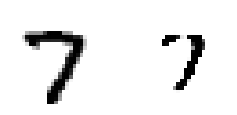

====> Epoch: 2 Average loss: -45448.9647


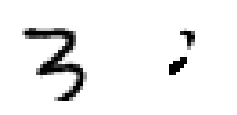

====> Epoch: 3 Average loss: -49803.8942


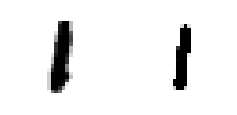

====> Epoch: 4 Average loss: -52399.3336


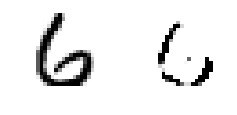

====> Epoch: 5 Average loss: -53948.8168


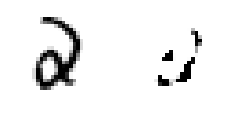

====> Epoch: 6 Average loss: -55162.6672


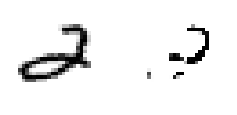

====> Epoch: 7 Average loss: -55827.7530


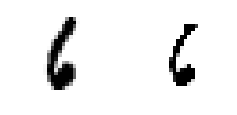

====> Epoch: 8 Average loss: -56236.1918


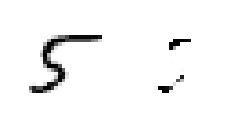

====> Epoch: 9 Average loss: -56622.0578


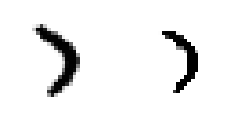

====> Epoch: 10 Average loss: -56718.7767


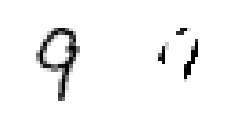

====> Epoch: 11 Average loss: -56986.0814


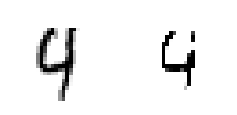

====> Epoch: 12 Average loss: -57128.1722


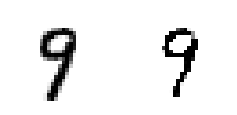

====> Epoch: 13 Average loss: -57096.5304


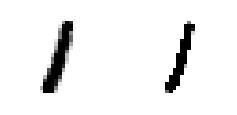

====> Epoch: 14 Average loss: -57080.9178


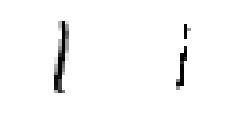

====> Epoch: 15 Average loss: -57177.5213


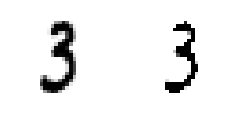

====> Epoch: 16 Average loss: -57232.2446


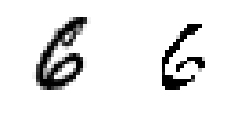

====> Epoch: 17 Average loss: -57145.6067


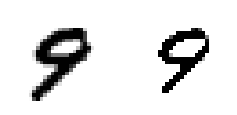

====> Epoch: 18 Average loss: -57010.3339


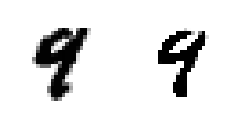

====> Epoch: 19 Average loss: -56852.2947


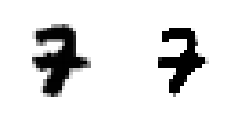

In [65]:
val_losses = train(train_loader, val_loader, num_epochs = 20)

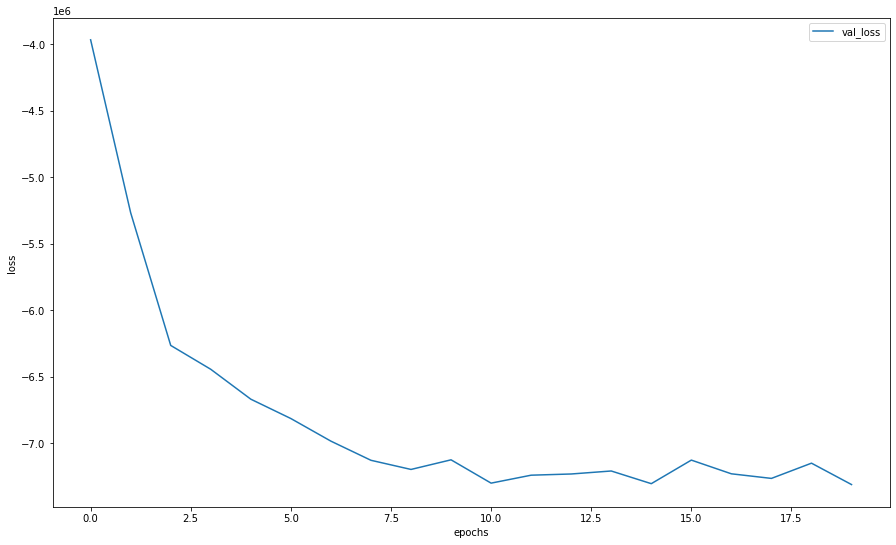

In [66]:

plt.figure(figsize=(15, 9))
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()